The dataset was downloaded from Kaggle (https://www.kaggle.com/kanishk307/6000-indian-food-recipes-dataset/notebooks), credit to @kanishk307 (GitHub). 

The dataset was quite clean, but still needed some data cleaning to be done.

In [352]:
import pandas as pd
import numpy as np

raw = pd.read_csv('datasets/IndianFoodDatasetCSV.csv')
df = raw.copy()

columns_to_drop = ['RecipeName', 'Ingredients', 'URL', 'PrepTimeInMins' , 'CookTimeInMins',
                        'TotalTimeInMins','TranslatedInstructions', 'Instructions', 'Servings', 'Srno']

df = df.drop(columns = columns_to_drop).dropna()

# data seems to contain more than just indian cuisines, so I drop these
cuisines_to_drop = ['Mexican', 'Italian Recipes', 'Thai', 'Chinese', 'Asian', 'Middle Eastern', 'European',
                   'Arab', 'Japanese', 'Vietnamese', 'British', 'Greek', 'French', 'Mediterranean', 'Sri Lankan',
                   'Indonesian', 'African', 'Korean', 'American', 'Carribbean', 'World Breakfast', 'Malaysian', 'Dessert',
                   'Afghan', 'Snack', 'Jewish', 'Brunch', 'Lunch', 'Continental', 'Fusion']

# need to drop desserts and breakfasts, as these are much less likely to contain spices
courses_to_drop = ['South Indian Breakfast', 'Snack', 'Appetizer', 'Indian Breakfast', 'Dessert', 'North Indian Breakfast',
                  'World Breakfast', 'Brunch', 'Side Dish']

df = df[~df['Cuisine'].isin(cuisines_to_drop)]
df = df[~df['Course'].isin(courses_to_drop)]
df.shape

(2333, 5)

In [354]:
df.head(15)

,TranslatedRecipeName,TranslatedIngredients,Cuisine,Course,Diet
1,Spicy Tomato Rice (Recipe),"2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",South Indian Recipes,Main Course,Vegetarian
3,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams Chicken,2 Onion - chopped,1 Tomato -...",Andhra,Lunch,Non Vegeterian
6,Udupi Style Ash Gourd Coconut Curry Recipe,500 grams Vellai Poosanikai (Ash gourd/White P...,Udupi,Lunch,Vegetarian
12,Andhra Steel Ingavu Charu Recipe - Asfoitida F...,"2 cup Tamarind Water,1/2 cup Arhar dal (Split ...",Andhra,Lunch,Vegetarian
13,And fish soup recipe - Bengali style fish in t...,600 grams Aar Maach (fish) - rohu/ katla fish ...,Bengali Recipes,Dinner,High Protein Non Vegetarian
14,Saunf Aloo (Fennel Potato Curry) Recipe,"5 Potatoes (Aloo) - halved with skin,2 teaspoo...",Punjabi,Lunch,Vegetarian
16,Hariyali Egg Curry Recipe In Coriander and Min...,"4 Whole Eggs - boiled,1 Cinnamon Stick (Dalchi...",Indian,Lunch,Eggetarian
19,Chettinad Vegetable Casserole Recipe - Chettin...,"1 cup rice - wash well in water, 12 small onio...",Chettinad,Dinner,Vegetarian
26,Mini Dal Samosa Curry / Sabzi Recipe,"3 Cardamom (Elaichi) Pods/Seeds,6 Whole Black ...",North Indian Recipes,Lunch,Vegetarian
31,Sundakkai and Methi Leaves Sambar Recipe - Sun...,"1/2 cup Sundkai, 1/4 cup fenugreek, 1/2 cup Ar...",South Indian Recipes,Lunch,Diabetic Friendly


In [355]:
#dataset contains hindi even in "translated" columns, dropping these for convenience sake
df = df['TranslatedIngredients']

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

#create boolean mask
mask = df.apply(isEnglish)
df = df[mask].dropna()

df.shape #I see we dropped about 350 entries.

(1986,)

In [395]:
#I am interested in only the recipe ingredients
recipes = df

#read file of all indian spices on wikipedia
raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_Indian_spices')
spices = raw[0]['Standard English'].copy().str.lower()

#some important spices I also added from experience/my own cookbook
add = pd.Series(['black mustard seed/raee', 'black salt', 'cumin powder'])

#some spices are too common (such as pepper) or not a spice, but a vegetable, or are otherwise corrupted (for example,
#cardamom is often listed as "cardamom" nto specifying whether it is black or green)
spices_to_drop = ['black pepper', 'peppercorns', 'capers', 'chili pepper powder', 'cinnamon buds', 'garlic',
                  'cumin seed ground into balls', 'dried ginger', 'green chili pepper', 'indian bedellium tree',
                 'indian gooseberry', 'mango extract', 'saffron pulp', 'black cumin']

spices = spices[~spices.isin(spices_to_drop)].append(add)

#editing the spices so that my string counter can find different versions of the same spice
spices = spices.str.replace('amchoor', 'amchur/amchoor') \
                    .replace('asafoetida', 'asafetida/asafoetida') \
                    .replace('alkanet root', 'alkanet/alkanet root') \
                    .replace('capsicum', 'CHILIPLACEHOLD') \
                    .replace('celery / radhuni seed', 'celery/radhuni seed') \
                    .replace('bay leaf, indian bay leaf', 'bay leaf/bay leaves') \
                    .replace('curry tree or sweet neem leaf', 'curry leaf/curry leaves') \
                    .replace('fenugreek leaf', 'fenugreek leaf/fenugreek leaves/kasoori methi') \
                    .replace('nigella seed', 'nigella seed/black cumin') \
                    .replace('thymol/carom seed', 'fenuthymol/carom seed') \
                    .replace('ginger', 'ginger/dried ginger/ginger powder') \
                    .replace('black cardamom', 'blackcardamom') \
                    .replace('green cardamom', 'cardamom') 


In [396]:
len(spices[spices.str.contains('cardamom')])
spices

0                              alkanet/alkanet root
1                                    amchur/amchoor
2                              asafetida/asafoetida
3                                     blackcardamom
8                                    CHILIPLACEHOLD
9                               celery/radhuni seed
10                                          charoli
12                              bay leaf/bay leaves
14                                         cinnamon
15                                      citric acid
16                                           cloves
17                                 coriander powder
18                                   coriander seed
19                                            cubeb
20                                       cumin seed
22                          curry leaf/curry leaves
23                                      fennel seed
24    fenugreek leaf/fenugreek leaves/kasoori methi
25                                   fenugreek seed
26          

### DICTIONARY OF SPICES

In [397]:
# iterate over each recipe and split into individual ingredients

words = []
for recipe in recipes:
    w = recipe.split(',')
    words.append(w)

# iterate over each sublist in list of ingredients and create one list (series), set to lowercase, strip whitespace
    
ing = [item for sublist in words for item in sublist]
ing = pd.Series(ing).str.strip()
ing = ing.str.lower()

# iterate over each row in ingredients, and then over each value in spices, to see if each spice is in the row. 
# Then create dictionary.

dict_of_spices = {key: 0 for key in spices}
for row in ing:
    for k in spices:
        k_new = k.split('/')
        for split in k_new:
            if split in row:
                dict_of_spices[k] += 1

# remove spices that had less than 20 occurences         
                
for key, value in dict_of_spices.copy().items():
    if value < 20:
        del dict_of_spices[key]


### LIST OF SPICES

In [398]:
# do the same as above except output is a list, not a dict

# iterate over each recipe and split into individual ingredients

words = []
for recipe in recipes:
    w = recipe.split(',')
    words.append(w)

# iterate over each sublist in list of ingredients and create one list (series), set to lowercase, strip whitespace
    
ing = [item for sublist in words for item in sublist]
ing = pd.Series(ing).str.strip()
ing = ing.str.lower()

list_of_spices = []
for row in ing:
    row = row.replace('red chili powder', 'CHILIPLACEHOLD').replace('red chilli powder','CHILIPLACEHOLD') \
            .replace('chilli flakes', 'CHILIPLACEHOLD').replace('chili flakes', 'CHILIPLACEHOLD') \
            .replace('red chilli','').replace('red chili', '') \
            .replace('green chilli', '').replace('green chili', '')
    row = row.replace('black cardamom', 'blackcardamom')
    for k in spices:
        k_new = k.split('/')
        for split in k_new:
            if split in row:
                k = k.capitalize()
                list_of_spices.append(k)
list_of_spices = pd.Series(list_of_spices)

# change back the spices for better readability and to include indian names where applicable

list_of_spices = list_of_spices.str.replace('Amchur/amchoor','Amchur (dried mango powder)') \
                                   .replace('Bay leaf/bay leaves','Bay leaves') \
                                    .replace('Chiliplacehold', 'Red chilli powder') \
                                    .replace('Asafetida/asafoetida','Asafetida (hing)') \
                                    .replace('Curry leaf/curry leaves','Curry leaves') \
                                    .replace('Fenuthymol/carom seed', 'Carom seed (ajwain)') \
                                    .replace('Fenugreek leaf/fenugreek leaves/kasoori methi','Fenugreek leaves (kasoori methi)') \
                                    .replace('Curry leaf/curry leaves','Curry leaves') \
                                    .replace('Cumin seed','Cumin seed (jeera)') \
                                    .replace('Black salt/kala namak','Black salt (kala namak)') \
                                    .replace('Nigella seed/black cumin','Nigella seed (black cumin)') \
                                    .replace('Celery/radhuni seed','Celery seed (radhuni)') \
                                    .replace('Ginger/dried ginger/ginger powder','Ginger') \
                                    .replace('Blackcardamom','Black cardamom') \
                                    .replace('Cardamom','Green cardamom') \
                                    .replace('Turmeric','Turmeric (haldi)') 

# count occurences of each spice
list_of_spices = pd.Series(list_of_spices).value_counts()

# exclude spices that are in less than 20 recipes out of all 5200
list_of_spices = list_of_spices[list_of_spices.values > 20]

# calculate a percentage of in how many recipes is each spice included
list_of_spices = pd.DataFrame(list_of_spices)
list_of_spices.columns = ['freq']
list_of_spices['perc'] = list_of_spices.apply(lambda x: round((x/len(recipes)),2))

#view
list_of_spices

,freq,perc
Turmeric (haldi),1395,0.70
Red chilli powder,1088,0.55
Ginger,1035,0.52
Cloves,975,0.49
Cumin seed (jeera),919,0.46
Curry leaves,658,0.33
Mustard seed,595,0.30
Coriander powder,586,0.30
Garam masala,542,0.27
Asafetida (hing),513,0.26


### PLOT 

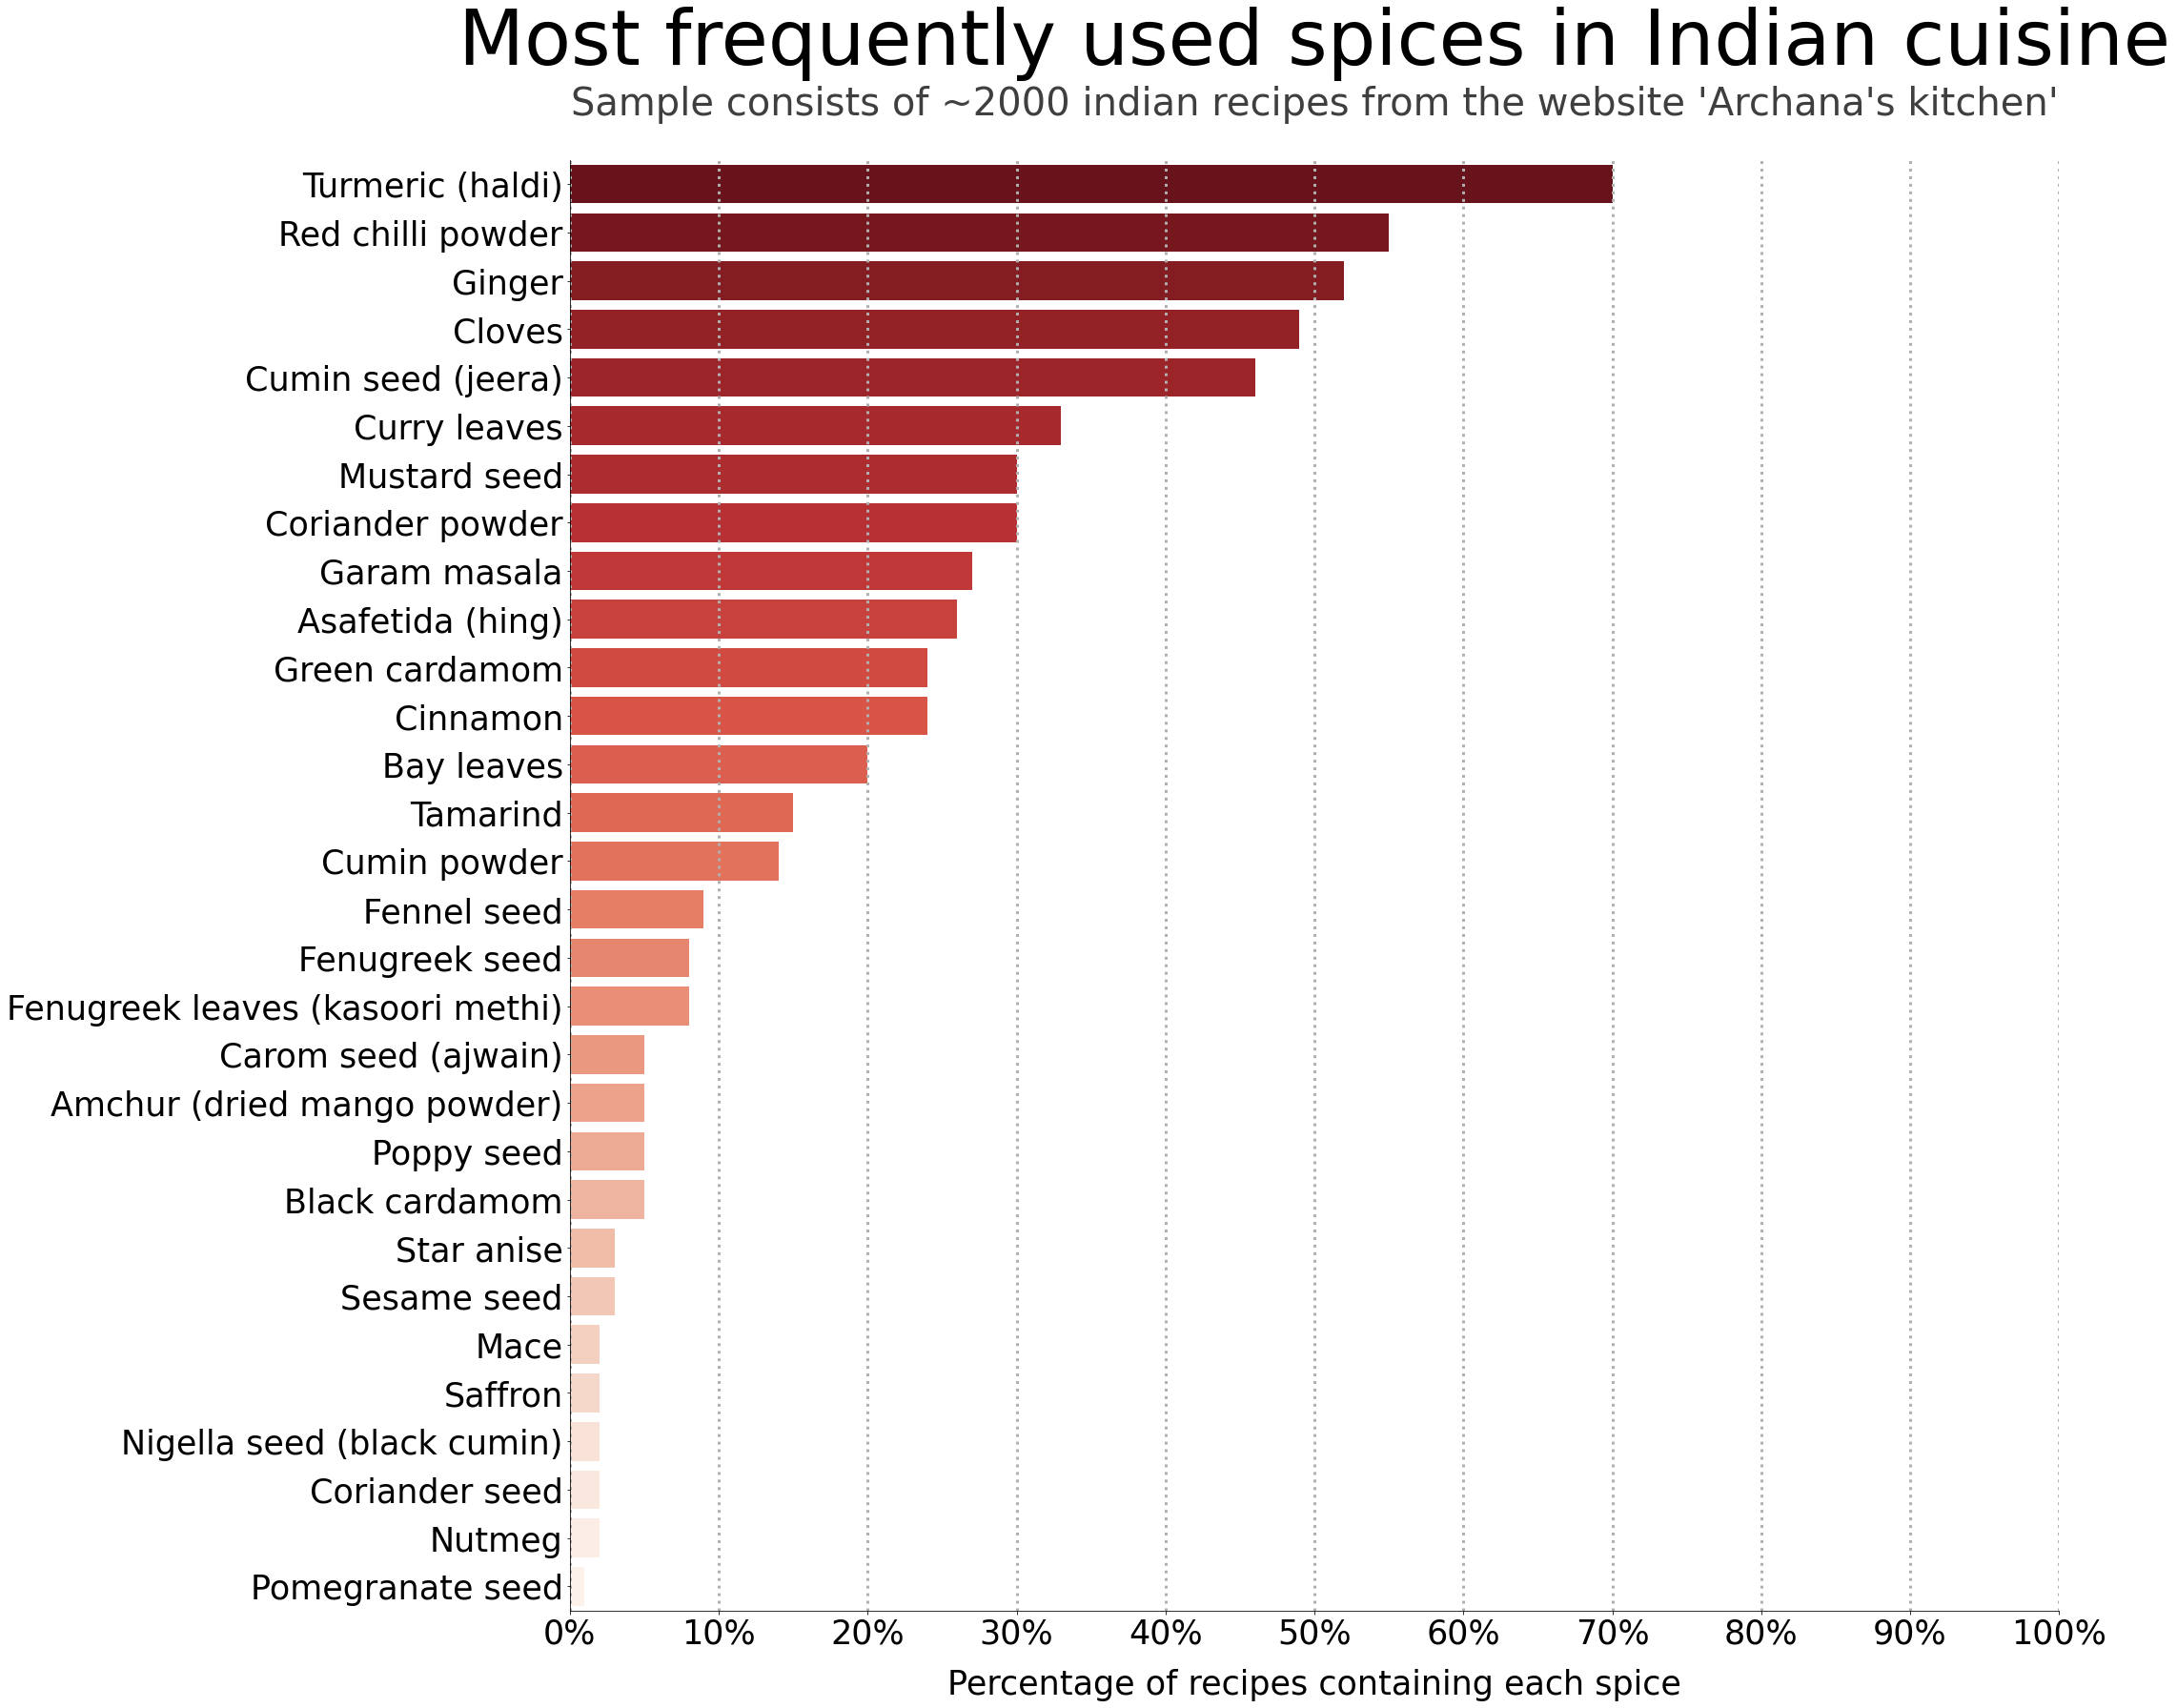

In [399]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

#create fig, axes
fig, ax = plt.subplots(figsize=(28, 28))

#create barplot
sns.barplot(y=list_of_spices.index, x=list_of_spices['perc'], 
            data = list_of_spices, orientation = 'horizontal',  palette="Reds_r")
plt.xticks(fontsize = 35);
plt.yticks(fontsize = 35);
sns.despine()

# titles, labels
ax.set_title('Most frequently used spices in Indian cuisine', fontsize = 80, pad = 100);
ax.text(x=0.5, y=1.025, s="Sample consists of ~2000 indian recipes from the website 'Archana's kitchen'", 
        fontsize=40, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes);
ax.set_xlabel('Percentage of recipes containing each spice', fontsize = 35, labelpad = 20);
ax.set_xticks(np.linspace(0,1,11), minor = False)

# set x axis to percentages
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 

# create grid for better readability
ax.grid(axis = 'x', linestyle = ':', linewidth = 3)